In [1]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import io
import requests
import pandas as pd
from pathlib import Path

In [2]:
### This is the local file path, but we decided to use an S3 bucket instead
# readpath = Path.cwd() / 'Data' / 'heart_failure_clinical_records_dataset.csv'
url="https://final-project-heart.s3.amazonaws.com/heart_failure_clinical_records_dataset.csv"
s=requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')))

In [3]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## Formatting Dataset for Models

In [4]:
target = df["DEATH_EVENT"]
target_names = ["living", "deceased"]

In [5]:
data = df.drop("DEATH_EVENT", axis=1)

In [6]:
feature_names = data.columns
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8


In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=3)

## Decision Tree Classifier

In [8]:
dtclf = tree.DecisionTreeClassifier()
dtclf = dtclf.fit(X_train, y_train)
dtclf.score(X_test, y_test)

0.68

In [9]:
sorted(zip(dtclf.feature_importances_, feature_names), reverse=True)

[(0.5106593017944883, 'time'),
 (0.12900232477838489, 'serum_creatinine'),
 (0.10739820184724909, 'serum_sodium'),
 (0.09414893056729408, 'ejection_fraction'),
 (0.056706250575347505, 'diabetes'),
 (0.04461667957747696, 'creatinine_phosphokinase'),
 (0.033411113645975425, 'age'),
 (0.024057197213783788, 'platelets'),
 (0.0, 'smoking'),
 (0.0, 'sex'),
 (0.0, 'high_blood_pressure'),
 (0.0, 'anaemia')]

In [10]:
# tree.plot_tree(dtclf)

## Random Forest Classifier

Number of Estimators: 1
Number of Estimators: 2
Number of Estimators: 3
Number of Estimators: 4
Number of Estimators: 5
Number of Estimators: 6
Number of Estimators: 7
Number of Estimators: 8
Number of Estimators: 9
Number of Estimators: 10
Number of Estimators: 11
Number of Estimators: 12
Number of Estimators: 13
Number of Estimators: 14
Number of Estimators: 15
Number of Estimators: 16
Number of Estimators: 17
Number of Estimators: 18
Number of Estimators: 19
Number of Estimators: 20
Number of Estimators: 21
Number of Estimators: 22
Number of Estimators: 23
Number of Estimators: 24
Number of Estimators: 25
Number of Estimators: 26
Number of Estimators: 27
Number of Estimators: 28
Number of Estimators: 29
Number of Estimators: 30
Number of Estimators: 31
Number of Estimators: 32
Number of Estimators: 33
Number of Estimators: 34
Number of Estimators: 35
Number of Estimators: 36
Number of Estimators: 37
Number of Estimators: 38
Number of Estimators: 39
Number of Estimators: 40
Number of

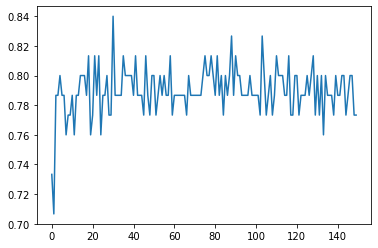

In [20]:
train = []
test = []
for x in range(150):
    RF_classifier = RandomForestClassifier(n_estimators=x+1)
    RF_classifier.fit(X_train, y_train)
    train.append(RF_classifier.score(X_train, y_train))
    test.append(RF_classifier.score(X_test, y_test))
    print(f"Number of Estimators: {x+1}")
plt.plot(test)

#### Sensitivity Study
Iterated over 0 to 300 estimators to find the what would yield the best model. It appears to reach a limit around 50 estimators, but we chose to go after the spike at 88 estimators for our model using all features. 

In [12]:
rf = RandomForestClassifier(n_estimators=88)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.8133333333333334

In [13]:
sorted(zip(rf.feature_importances_, feature_names), reverse=True)

[(0.3477721185967737, 'time'),
 (0.13637621497661395, 'serum_creatinine'),
 (0.11868009637117076, 'ejection_fraction'),
 (0.1012089314359698, 'age'),
 (0.08806518673561976, 'serum_sodium'),
 (0.07624206065528356, 'creatinine_phosphokinase'),
 (0.07195168060687615, 'platelets'),
 (0.013806841888913056, 'anaemia'),
 (0.013595810614731285, 'smoking'),
 (0.01210097146020404, 'high_blood_pressure'),
 (0.01075418437734932, 'diabetes'),
 (0.00944590228049471, 'sex')]

In [18]:
predictions = rf.predict(X_test)
print(classification_report(y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

      living       0.81      0.89      0.85        53
    deceased       0.65      0.50      0.56        22

    accuracy                           0.77        75
   macro avg       0.73      0.69      0.71        75
weighted avg       0.76      0.77      0.76        75



#### Using only patient-known factors

In [24]:
patient_known_data = df.drop(["time","creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium", "DEATH_EVENT"], axis=1)
feature_names = patient_known_data.columns
patient_known_data.head()

,age,anaemia,diabetes,high_blood_pressure,sex,smoking
0,75.0,0,0,1,1,0
1,55.0,0,0,0,1,0
2,65.0,0,0,0,1,1
3,50.0,1,0,0,1,0
4,65.0,1,1,0,0,0


In [25]:
X_train, X_test, y_train, y_test = train_test_split(patient_known_data, target, random_state=5)

In [26]:
rf = RandomForestClassifier(n_estimators=88)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.64

In [27]:
sorted(zip(rf.feature_importances_, feature_names), reverse=True)

[(0.7189307921868706, 'age'),
 (0.06274910381243914, 'smoking'),
 (0.059216740418471484, 'diabetes'),
 (0.05820924199882521, 'high_blood_pressure'),
 (0.05111339121413866, 'sex'),
 (0.049780730369255066, 'anaemia')]

In [28]:
predictions = rf.predict(X_test)
print(classification_report(y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

      living       0.74      0.75      0.75        53
    deceased       0.38      0.36      0.37        22

    accuracy                           0.64        75
   macro avg       0.56      0.56      0.56        75
weighted avg       0.64      0.64      0.64        75

